# Вебинар 2. Бейзлайны и детерминированные алгоритмы item-item

In [358]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix, coo_matrix

import warnings
warnings.filterwarnings("ignore")

## Загрузка и подготовка данных

In [359]:
data = pd.read_csv('./data/retail_train.csv')
data.head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0
5,2375,26984851516,1,826249,2,1.98,364,-0.60,1642,1,0.0,0.0
6,2375,26984851516,1,1043142,1,1.57,364,-0.68,1642,1,0.0,0.0
7,2375,26984851516,1,1085983,1,2.99,364,-0.40,1642,1,0.0,0.0
8,2375,26984851516,1,1102651,1,1.89,364,0.00,1642,1,0.0,0.0
9,2375,26984851516,1,6423775,1,2.00,364,-0.79,1642,1,0.0,0.0


In [360]:
data['week_no'].nunique()

95

In [361]:
users, items, interactions = data.user_id.nunique(), data.item_id.nunique(), data.shape[0]

print('# users: ', users)
print('# items: ', items)
print('# interactions: ', interactions)

# users:  2499
# items:  89051
# interactions:  2396804


**Note:**  
Еще есть данные по характеристикам товаров и пользователей. Они нам пригодятся через несколько вебинаров

In [362]:
item_features = pd.read_csv('./data/product.csv')
item_features.head(2)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [363]:
user_features = pd.read_csv('./data/hh_demographic.csv')
user_features.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


### Train-test split

В рекомендательных системах корректнее использовать train-test split по времени, а не случайно  
Я возьму последние 3 недели в качестве теста

In [364]:
test_size_weeks = 3

data_train = data[data['week_no'] < data['week_no'].max() - test_size_weeks]
data_test = data[data['week_no'] >= data['week_no'].max() - test_size_weeks]

In [365]:
data_train.shape[0], data_test.shape[0]

(2278490, 118314)

# 1. Бейзлайны

Создадим датафрейм с покупками юзеров на тестовом датасете (последние 3 недели)

In [366]:
result = data_test.groupby('user_id')['item_id'].unique().reset_index()
result.columns=['user_id', 'actual']
result.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


In [367]:
test_users = result.shape[0]
new_test_users = len(set(data_test['user_id']) - set(data_train['user_id']))

print('В тестовом дата сете {} юзеров'.format(test_users))
print('В тестовом дата сете {} новых юзеров'.format(new_test_users))

В тестовом дата сете 2042 юзеров
В тестовом дата сете 0 новых юзеров


### 1.1 Random recommendation

In [368]:
def random_recommendation(items, n=5):
    """Случайные рекомендации"""
    
    items = np.array(items)
    recs = np.random.choice(items, size=n, replace=False)
    
    return recs.tolist()

In [369]:
%%time

items = data_train.item_id.unique()

result['random_recommendation'] = result['user_id'].map(lambda x: random_recommendation(items, n=5))
result.head(2)

CPU times: total: 6.73 s
Wall time: 6.76 s


,user_id,actual,random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[116612, 1181676, 15596801, 1121402, 12748387]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13095521, 1199526, 1133686, 841159, 521069]"


### 1.2 Popularity-based recommendation

In [370]:
def popularity_recommendation(data, n=5):
    """Топ-n популярных товаров"""
    
    popular = data.groupby('item_id')['sales_value'].sum().reset_index()
    popular.sort_values('sales_value', ascending=False, inplace=True)
    
    recs = popular.head(n).item_id
    
    return recs.tolist()

In [371]:
%%time

# Можно так делать, так как рекомендация не зависит от юзера
popular_recs = popularity_recommendation(data_train, n=5)

result['popular_recommendation'] = result['user_id'].map(lambda x: popular_recs)
result.head(2)

CPU times: total: 188 ms
Wall time: 185 ms


,user_id,actual,random_recommendation,popular_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[116612, 1181676, 15596801, 1121402, 12748387]","[6534178, 6533889, 1029743, 6534166, 1082185]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13095521, 1199526, 1133686, 841159, 521069]","[6534178, 6533889, 1029743, 6534166, 1082185]"


# Задание 1
### 1.3 Weighted random recommender

- Можно сэмплировать товары случайно, но пропорционально какому-либо весу
- Например, прямопропорционально популярности. Вес = log(sales_sum товара)

*Пример*  
item_1 - 5, item_2 - 7, item_3 - 4  # / sum  
item_1 - 5 / 16, item_2 - 7 / 16, item_3 - 4 / 16

In [420]:
def weights(data):
    
    items_weights = data.groupby('item_id')['sales_value'].sum().reset_index()
    items_weights['weight'] = items_weights.sales_value / items_weights.sales_value.sum()
    items_weights.drop(columns='sales_value', inplace=True)
    
    return items_weights

In [421]:
def weighted_random_recommendation(items_weights, n=5):
    """Случайные рекоммендации
    
    Input
    -----
    items_weights: pd.DataFrame
        Датафрейм со столбцами item_id, weight. Сумма weight по всем товарам = 1
    """
    
    recs = np.random.choice(items_weights.item_id, size=n, replace=False,
                        p=np.array(items_weights.weight)
                       )
    
    return recs.tolist()

In [422]:
%%time

items_weights = weights(data_train) # нахождение весов предметов

result['weighted_random_recommendation'] = result['user_id'].apply(lambda x: weighted_random_recommendation(items_weights))
result.head(2)

CPU times: total: 781 ms
Wall time: 781 ms


,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[116612, 1181676, 15596801, 1121402, 12748387]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[6534178, 999999, 907392, 983000, 981521]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13095521, 1199526, 1133686, 841159, 521069]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[854852, 999999, 905636, 901776, 6534178]"


### Выводы по бейзлайнам
- Фиксируют базовое качество;
- Бейзлайны могут быть фильтрами;
- Иногда бейзлайны лучше ML-модели

# 2. Детерминированные алгоритмы item-item

[Implicit](https://implicit.readthedocs.io/en/latest/quickstart.html) - очень быстрая и 
эффективная библиотека для рекоммендаций

Основные фичи:
    - Cython под капотом - высокая скорость
    - Множество приближенных алгоритмов - быстрее, чем оригинальные
    - Содежрит большинство популярных алгоритмов
    - Есть алгоритмы ранжирования
    - Поиск похожих товаров / юзеров
    - Есть возможность пересчета "холодного" юзера "на лету"
    - Возможность фильтровать товары при рекомендациях (Например, не рекомендовать женские товары мужчинам)
    - Есть метрики качества

In [423]:

# Детерминированные алгоритмы
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender, TFIDFRecommender, BM25Recommender

# Метрики
from implicit.evaluation import train_test_split
from implicit.evaluation import precision_at_k, mean_average_precision_at_k, AUC_at_k, ndcg_at_k

In [424]:
import implicit
implicit.__version__

'0.6.1'

Алгоритмы строятся на основе матрицы взаимодействийю
То, что именно находится в матрице user-item нужно определять из бизнес-логики

Варианты для нашего датасета(не исчерпывающий список):
    - Факт покупки (0 / 1)
    - Кол-во покупок (count)
    - Сумма покупки, руб
    - ...
    
**Детерминированные алгоритмы**:
    - Предсказывают те числа, которые стоят в матрице

**ML-алгоритмы (большинство)**:
    - В качестве *таргетов* "под капотом" принимают 0 и 1 (в ячейке не 0 -> таргет 1)
    - А абсолютные значения воспринимают как *веса ошибок*
    
*P.S.* На самом деле есть много трюков, как можно заполнять матрицу user-item. Об этом мы поговорим на следующих вебинарах

## 2.1 Item-Item Recommender / ItemKNN


**(!) Важно** 
- У item-item алгоритмов большая сложность predict ($O(I^2 log(I))$ или $O(I^3)$, в зависимости от реализации 
- Если в датасете много item_id, то item-item модели ОЧЕНЬ долго предсказывают. Со всеми товарами predict на тесте ~2 часа
- Давайте возьмем из ~90к товаров только 5k самых популярных 

*P.S.*  Брать топ-Х популярных и рекомендовать только из них - очень популярная стратегия.   
*P.P.S.*  В рекомендательных системах много таких трюков. Что-то подобное в курсе вы увидите еще не раз

In [425]:
popularity = data_train.groupby('item_id')['quantity'].sum().reset_index()
popularity.rename(columns={'quantity': 'n_sold'}, inplace=True)

popularity.head()

,item_id,n_sold
0,202291,35911
1,397896,1214994
2,420647,168661
3,480014,371107
4,545926,20134


In [426]:
top_5000 = popularity.sort_values('n_sold', ascending=False).head(5000).item_id.tolist()

In [427]:
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id']

29429      977033
45968      977033
86155      977033
106617     977033
134538     977033
            ...  
2205077    977033
2213525    977033
2229984    977033
2234317    977033
2243711    977033
Name: item_id, Length: 63, dtype: int64

In [428]:
# Заведем фиктивный item_id (если юзер покупал товары не из топ-5000, то он "купил" такой товар)
data_train.loc[~data_train['item_id'].isin(top_5000), 'item_id'] = 999999

user_item_matrix = pd.pivot_table(data_train, 
                                  index='user_id', columns='item_id', 
                                  values='quantity',
                                  aggfunc='count', 
                                  fill_value=0
                                 )

user_item_matrix[user_item_matrix > 0] = 1 # так как в итоге хотим предсказать 
user_item_matrix = user_item_matrix.astype(float) # необходимый тип матрицы для implicit

# переведем в формат saprse matrix
sparse_user_item = csr_matrix(user_item_matrix).tocsr()

user_item_matrix.head(3)

item_id,202291,397896,420647,480014,545926,707683,731106,818980,819063,819227,...,15778533,15831255,15926712,15926775,15926844,15926886,15927403,15927661,15927850,16809471
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [429]:
sparse_user_item

<2499x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 667028 stored elements in Compressed Sparse Row format>

In [430]:
user_item_matrix.sum().sum() / (user_item_matrix.shape[0] * user_item_matrix.shape[1]) * 100

5.338359343737495

Для работы с матрицами заведем словари перевода идентификаторов в индексы матриц и обратно

In [431]:
userids = user_item_matrix.index.values
itemids = user_item_matrix.columns.values

matrix_userids = np.arange(len(userids))
matrix_itemids = np.arange(len(itemids))

id_to_itemid = dict(zip(matrix_itemids, itemids))
id_to_userid = dict(zip(matrix_userids, userids))

itemid_to_id = dict(zip(itemids, matrix_itemids))
userid_to_id = dict(zip(userids, matrix_userids))

In [432]:
%%time

model = ItemItemRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(sparse_user_item,  # На вход item-user matrix
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2],  # userid - id от 0 до N
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, # кол-во рекомендаций 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], 
                        recalculate_user=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: total: 2.22 s
Wall time: 609 ms


In [433]:
recs

(array([3586, 2306, 2147, 3946, 3407]),
 array([ 7431., 12981., 43806., 17219., 56269.]))

In [434]:
[id_to_itemid[rec] for rec in recs[0]]

[1098066, 995242, 981760, 1127831, 1082185]

In [435]:
1082185, 981760, 1098066, 995242, 1127831, 826249

(1082185, 981760, 1098066, 995242, 1127831, 826249)

In [436]:
%%time
result['itemitem'] = result['user_id'].\
    map(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=True)[0]])

CPU times: total: 141 ms
Wall time: 138 ms


In [437]:
result.head(5)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[116612, 1181676, 15596801, 1121402, 12748387]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[6534178, 999999, 907392, 983000, 981521]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13095521, 1199526, 1133686, 841159, 521069]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[854852, 999999, 905636, 901776, 6534178]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[827133, 15926392, 15686742, 6603362, 821477]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[999999, 1079913, 981760, 965766, 6534178]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[16101795, 8358308, 35309, 1076723, 10250109]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[1115576, 9707137, 999999, 1127831, 1015539]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[948381, 109746, 13411728, 6772846, 958450]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[883003, 854405, 999999, 1051069, 878996]"


Попробуем воспроизвести этот алгоритмо вручную

In [438]:
similarity= (sparse_user_item.T@sparse_user_item).toarray()
for ind,row in enumerate(similarity):
    row[ind]=0
    best=row.argsort()[::-1][:5]
    mask = np.ones(row.shape, bool)
    mask[best] = False
    row[mask]=0

    
similarity=csr_matrix(similarity)
        
    

In [439]:
ii_res=(sparse_user_item[userid_to_id[2]]@similarity).toarray().ravel()

[ii_res[rec] for rec in ii_res.argsort()[::-1][:7]]

[76181.0, 70158.0, 58945.0, 24948.0, 19519.0, 18366.0, 14163.0]

In [440]:
[id_to_itemid[rec] for rec in ii_res.argsort()[::-1][:7]]

[999999, 1082185, 981760, 1098066, 995242, 1127831, 826249]

### 2.2 Косинусное сходство и CosineRecommender

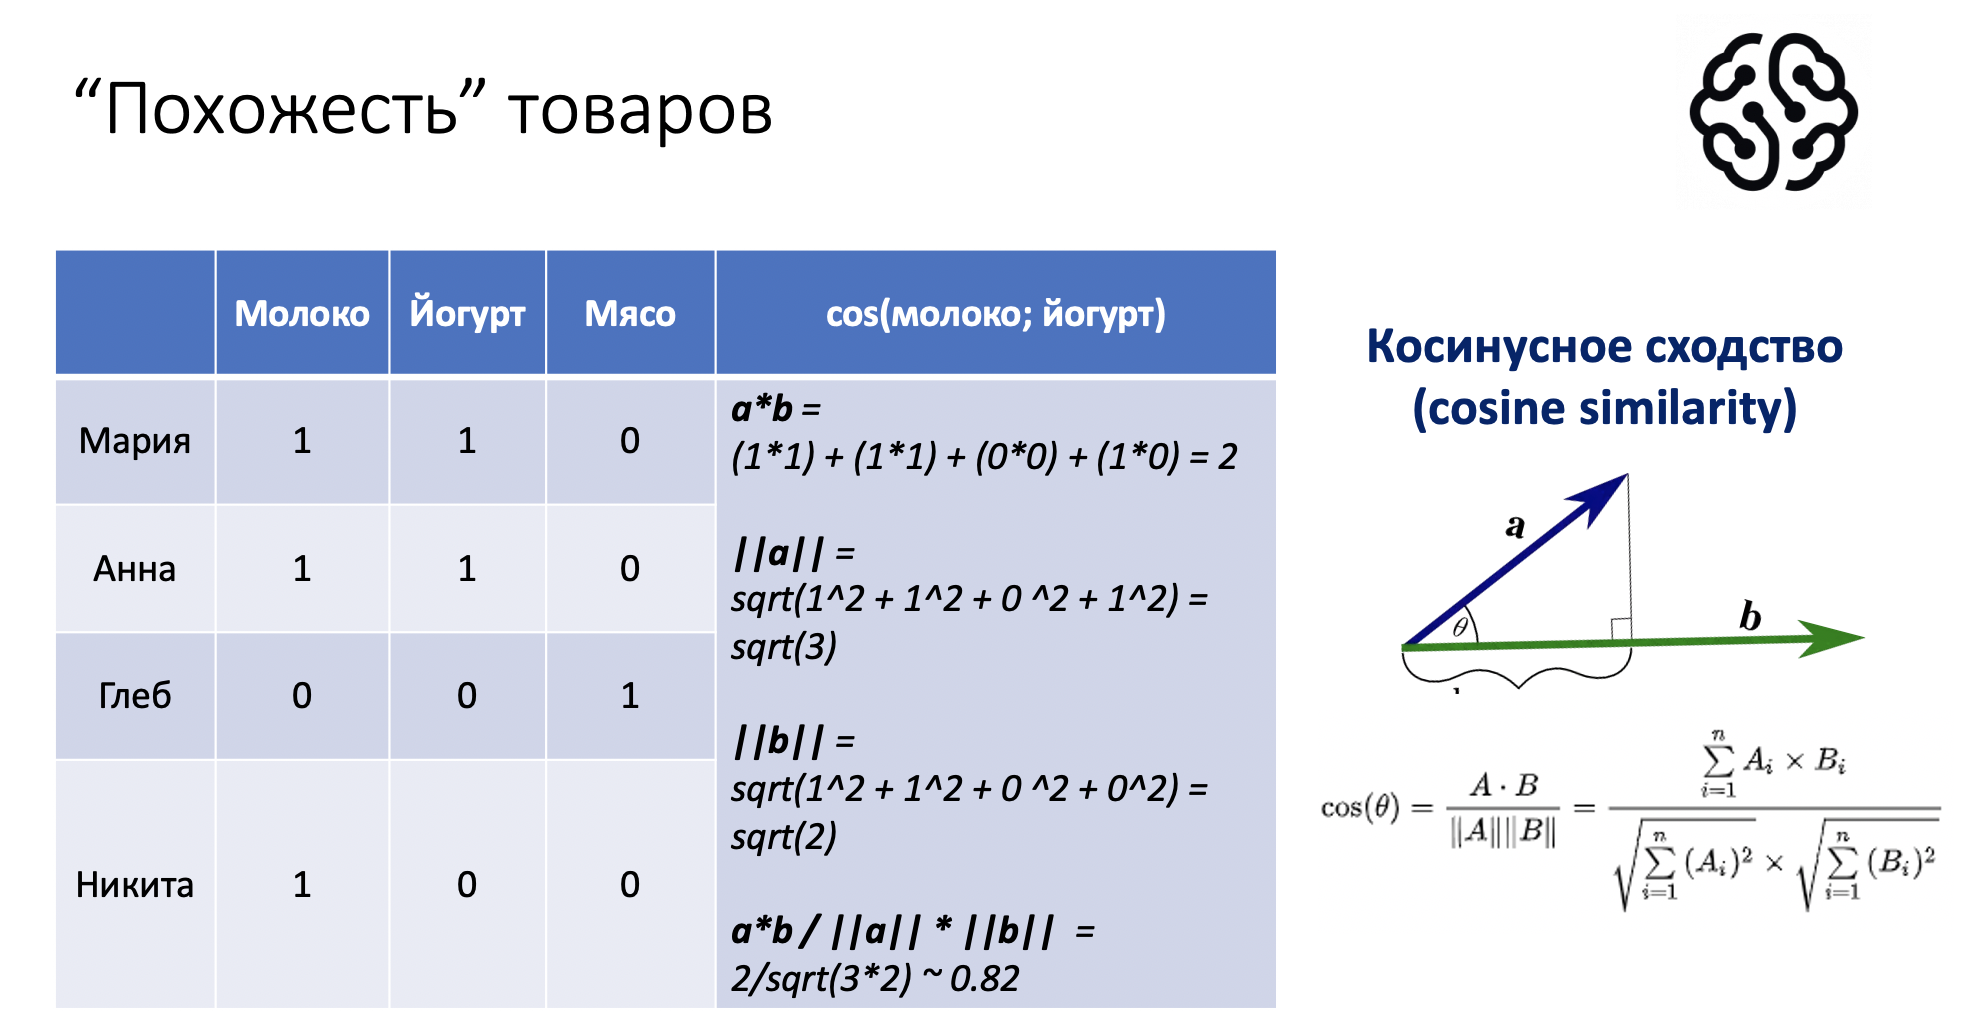

In [441]:
%%time

model = CosineRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], 
                        recalculate_user=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: total: 2.5 s
Wall time: 944 ms


In [442]:
[id_to_itemid[rec] for rec in recs[0]]

[961554, 1098066, 1127831, 981760, 1082185]

In [443]:
%%time

result['cosine'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])

CPU times: total: 328 ms
Wall time: 126 ms


In [444]:
result.head(10)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[116612, 1181676, 15596801, 1121402, 12748387]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[6534178, 999999, 907392, 983000, 981521]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13095521, 1199526, 1133686, 841159, 521069]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[854852, 999999, 905636, 901776, 6534178]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[827133, 15926392, 15686742, 6603362, 821477]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[999999, 1079913, 981760, 965766, 6534178]"
3,7,"[840386, 889774, 898068, 909714, 929067, 95347...","[16101795, 8358308, 35309, 1076723, 10250109]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[1115576, 9707137, 999999, 1127831, 1015539]"
4,8,"[835098, 872137, 910439, 924610, 992977, 10412...","[948381, 109746, 13411728, 6772846, 958450]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[883003, 854405, 999999, 1051069, 878996]"
5,9,"[864335, 990865, 1029743, 9297474, 10457112, 8...","[966472, 1819643, 902943, 9553134, 13909606]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[6534166, 1104414, 1131374, 948495, 9524291]"
6,13,"[6534178, 1104146, 829197, 840361, 862070, 884...","[1062152, 12757324, 990762, 1064408, 5129570]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[999999, 1106523, 1098066, 874972, 981760]"
7,14,"[840601, 867293, 933067, 951590, 952408, 96569...","[867759, 1211220, 835634, 1106145, 953339]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[1082185, 1005609, 999999, 6534178, 1132763]"
8,15,"[910439, 1082185, 959076, 1023958, 1082310, 13...","[12301378, 945914, 835279, 15927134, 14077682]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[999999, 12524323, 905072, 880150, 997796]"
9,16,"[1062973, 1082185, 13007710]","[8068640, 1048300, 12457233, 13115999, 9885566]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[12428017, 999999, 824303, 6534178, 12301109]"


### 2.3 TF-IDF взвешивание и TFIDFRecommender

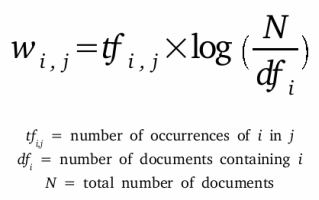

Если 2 юзера оба купили очень популярный товар, то это еще не значит,что они похожи   
Если 2 юзера оба купили редкий товар, то они похожи

Занижаем вес популярных товаров при расчете расстояний между пользователями

Пользователь соответсвует слову, Объект - документу

In [445]:
%%time

model = TFIDFRecommender(K=5, num_threads=4) # K - кол-во билжайших соседей

model.fit(csr_matrix(user_item_matrix).tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[1], 
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], 
                        recalculate_user=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: total: 2.39 s
Wall time: 935 ms


In [446]:
[id_to_itemid[rec] for rec in recs[0]]

[961554, 1098066, 1127831, 981760, 1082185]

In [447]:
%%time

result['tfidf'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])

CPU times: total: 312 ms
Wall time: 129 ms


In [448]:
result.head(2)

,user_id,actual,random_recommendation,popular_recommendation,itemitem,cosine,tfidf,own_purchases,weighted_random_recommendation
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[116612, 1181676, 15596801, 1121402, 12748387]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[6534178, 999999, 907392, 983000, 981521]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[13095521, 1199526, 1133686, 841159, 521069]","[6534178, 6533889, 1029743, 6534166, 1082185]","[1098066, 995242, 981760, 1127831, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[961554, 1098066, 1127831, 981760, 1082185]","[1081177, 995785, 1004906, 1082185, 1029743]","[854852, 999999, 905636, 901776, 6534178]"


### 2.4 Поменяем немного гиперпараметры

In [449]:
%%time

model = ItemItemRecommender(K=1, num_threads=4) # K - кол-во ближайших соседей

model.fit(csr_matrix(user_item_matrix).tocsr(), 
          show_progress=True)

recs = model.recommend(userid=userid_to_id[2], 
                        user_items=sparse_user_item,   # на вход user-item matrix
                        N=5, 
                        filter_already_liked_items=False, 
                        filter_items=[itemid_to_id[999999]], 
                        recalculate_user=False)

  0%|          | 0/5000 [00:00<?, ?it/s]

CPU times: total: 2.5 s
Wall time: 917 ms


In [450]:
[id_to_itemid[rec] for rec in recs[0]]

[1081177, 995785, 1004906, 1082185, 1029743]

In [451]:
recs

(array([3396, 2315, 2433, 3407, 2756]),
 array([1048., 1170., 1098., 2233., 1317.]))

In [452]:
%%time

result['own_purchases'] = result['user_id'].\
    apply(lambda x: [id_to_itemid[rec] for rec in 
                    model.recommend(userid=userid_to_id[x], 
                                    user_items=sparse_user_item,   # на вход user-item matrix
                                    N=5, 
                                    filter_already_liked_items=False, 
                                    filter_items=[itemid_to_id[999999]], 
                                    recalculate_user=False)[0]])

CPU times: total: 219 ms
Wall time: 112 ms


# Задание 2. Расчет метрик

In [453]:
result.to_csv('../predictions_basic.csv', index=False)

Можно ли улучшить бейзлайны, если считать их на топ-5000 товарах?

In [454]:
def precision_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list
    recommended_list = recommended_list[:k]
    
    flags = np.isin(recommended_list, bought_list)
    
    precision = flags.sum() / len(recommended_list)
    
    
    return precision


In [455]:
def recall_at_k(recommended_list, bought_list, k=5):
    
    bought_list = np.array(bought_list)
    recommended_list = np.array(recommended_list)
    
    bought_list = bought_list
    recommended_list = recommended_list[:k]
    
    flags = np.isin(bought_list, recommended_list)
    
    recall = flags.sum() / len(bought_list)
    
    return recall

In [456]:
metrics = pd.DataFrame(data={'metrics': ['Precision@5', 'Precision@3', 'Recall@5'],
                            'random_recommendation': [0, 0, 0],
                            'popular_recommendation': [0, 0, 0],
                            'weighted_random_recommendation': [0, 0, 0],
                            'itemitem': [0, 0, 0],
                            'cosine': [0, 0, 0],
                            'tfidf': [0, 0, 0],
                            'own_purchases': [0, 0, 0],
                            })

In [457]:
for col in result.columns[2:]:
    metrics[col][0] = result.apply(lambda row: precision_at_k(row[col], row['actual']), axis=1).mean()
    metrics[col][1] = result.apply(lambda row: precision_at_k(row[col], row['actual'], 3), axis=1).mean()
    metrics[col][2] = result.apply(lambda row: recall_at_k(row[col], row['actual']), axis=1).mean()

In [458]:
metrics

,metrics,random_recommendation,popular_recommendation,weighted_random_recommendation,itemitem,cosine,tfidf,own_purchases
0,Precision@5,0.000490,0.155240,0.031146,0.145739,0.135455,0.135455,0.162292
1,Precision@3,0.000326,0.137773,0.031015,0.119654,0.058929,0.058929,0.087496
2,Recall@5,0.000028,0.024996,0.004443,0.016218,0.014031,0.014031,0.018309


# Задание 3*. Улучшение бейзлайнов и ItemItem
Попробуйте улучшить бейзлайны, считая их на топ-5000 товаров
Попробуйте улучшить разные варианты ItemItemRecommender, выбирая число соседей  𝐾 .